In [47]:
import os, pathlib
os.chdir("/Users/gregcc/Documents/GitHub/SURP25/Microlensing")

In [48]:
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from ML import TwoLens1S
from ML import ThreeLens1S

## Set Up of "Standard" System

In [ ]:
m1 = 0.3 #Lens Star Mass (Solar Mass)
m2 = 0.0002857 #Lens Planet Mass (Saturn Mass in Solar Mass)
m3 = 3.003e-6 #Lens Moon (Earth Mass in Solas Mass)

M_total = m1 + m2+ m3

D_l = 7.59 #kpc
D_s = 8.55 #kpc

s2 = 1.3 #R_E (Star-Planet Separation)
d = 0.1 #R_E (Planet-Moon Separation)

q2 = m2/m1
q3 = m3/m1

print(q2, q3, m3/m1)

# Event parameters
t0 = 0
tE = 20
rho = 0.001
rs = rho
u0_list = [0.1]


secnum = 45
basenum = 2
num_points = 1000

0.0009523333333333334 1.001e-05 1.001e-05


In [98]:
q4 = (m2+m3)/m1
print(q4, q3, q2)

0.0009623433333333334 1.001e-05 0.0009523333333333334


In [50]:
def Einstein_Radius(M_solar, D_l_kpc, D_s_kpc):
    """
    Computes the Einstein Radius.

    Parameters:
    M_solar : float
        Mass of the lens in Solar masses
    D_l_kpc : float
        Distance to the lens in kpc
    D_s_kpc : float
        Distance to the source in kpc

    Returns:
    R_E : float
        Einstein radius in meters
    theta_E_arcsec : float
        Einstein radius in arcseconds
    theta_E_mas : float
        Einstein radius in milliarcseconds
    """
    # Constants
    c = 3e8            # speed of light in m/s
    G = 6.674e-11      # gravitational constant in N m^2 / kg^2
    M_sun = 1.989e30   # kg
    kpc_to_m = 3.086e19  # meters
    rad_to_arcsec = 206265  # arcsec per radian

    # Convert inputs
    M = M_solar * M_sun
    D_l = D_l_kpc * kpc_to_m
    D_s = D_s_kpc * kpc_to_m
    D_ls = D_s - D_l

    # Einstein radius in meters
    R_E = ((4 * G * M / c**2) * (D_ls * D_l / D_s)) ** 0.5

    # Angular Einstein radius in radians
    theta_E_rad = R_E / D_l

    # Convert to arcsec and mas
    theta_E_arcsec = theta_E_rad * rad_to_arcsec
    theta_E_mas = theta_E_arcsec * 1000

    return R_E, theta_E_arcsec, theta_E_mas


In [51]:
def Moon_Geometry(s2, d, phi_deg):
    """
    Compute s3 and psi given planet position s2, planet-moon distance d,
    and angle phi (degrees) measured from the star-planet axis.
    
    Returns
    -------
    s3 : float
        Star-moon separation (in Einstein radius units)
    psi : float
        Angle of moon relative to x-axis (radians)
    """
    phi = np.radians(phi_deg)
    x_m = s2 + d * np.cos(phi)
    y_m = d * np.sin(phi)
    
    s3 = np.sqrt(x_m**2 + y_m**2)
    psi_deg = np.degrees(np.arctan2(y_m, x_m))
    return s3, psi_deg


In [143]:
print(Moon_Geometry(s2, d, 180))

(np.float64(1.2), np.float64(5.847257748779064e-16))


In [53]:
s3 = 1.3038
psi = 4.39

In [54]:
R_E, theta_E_arcsec, theta_E_mas = Einstein_Radius(M_total, D_l, D_s)

print(f"Einstein Radius: {R_E:.2e} m")
print(f"Angular Einstein Radius: {theta_E_arcsec:.4f} arcsec")
print(f"Angular Einstein Radius: {theta_E_mas:.2f} mas")

Einstein Radius: 2.16e+11 m
Angular Einstein Radius: 0.0002 arcsec
Angular Einstein Radius: 0.19 mas


In [55]:
tau_lc = np.linspace(-4, 4, 1000)
t_lc = t0 + tau_lc * tE

In [73]:
double_model = TwoLens1S(t0, tE, rho, u0_list, q2, s2, 25, t_lc)

In [74]:
double_model_tau = double_model.tau_lc
double_model_mag = double_model.systems[0]["mag"]

In [58]:
triple_model = ThreeLens1S(t0, tE, rho, u0_list, q2, q3, s2, s3, 25, psi, rs, secnum, basenum, num_points)

param = [
    np.log(triple_model.s2), np.log(triple_model.q2), triple_model.u0_list[0], triple_model.alpha_deg,
    np.log(triple_model.rho), np.log(triple_model.tE), triple_model.t0,
    np.log(triple_model.s3), np.log(triple_model.q3), triple_model.psi_rad
]
mag, *_ = triple_model.VBM.TripleLightCurve(param, triple_model.highres_t)

# now you have
triple_model_tau = triple_model.highres_tau
triple_model_mag = mag

In [59]:
np.savez("trial1.npz",
         tau=triple_model_tau,
         mag=triple_model_mag)

In [60]:
data = np.load("trial1.npz")
triple_model_tau = data['tau']
triple_model_mag = data['mag']

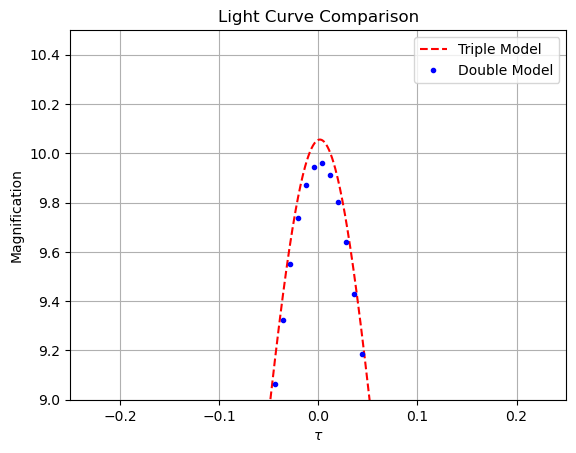

In [61]:
plt.plot(triple_model_tau, triple_model_mag, '--', label = "Triple Model", color = 'red')
plt.plot(double_model_tau, double_model_mag, '.b', label="Double Model")

plt.xlim(-.25, .25)
plt.ylim(9, 10.5)

plt.xlabel(r"$\tau$")
plt.ylabel("Magnification")
plt.title("Light Curve Comparison")
plt.grid(True)
plt.legend()
plt.show()

In [62]:
two_system = double_model.systems[0]
three_system = triple_model.systems[0]

# Differences relative to source
delta_x_two = two_system['cent_x_hr'] - two_system['x_src_hr']
delta_y_two = two_system['cent_y_hr'] - two_system['y_src_hr']

delta_x_three = three_system['cent_x'] - three_system['y1s']
delta_y_three = three_system['cent_y'] - three_system['y2s']

delta_x_three = - delta_x_three
delta_y_three = delta_y_three

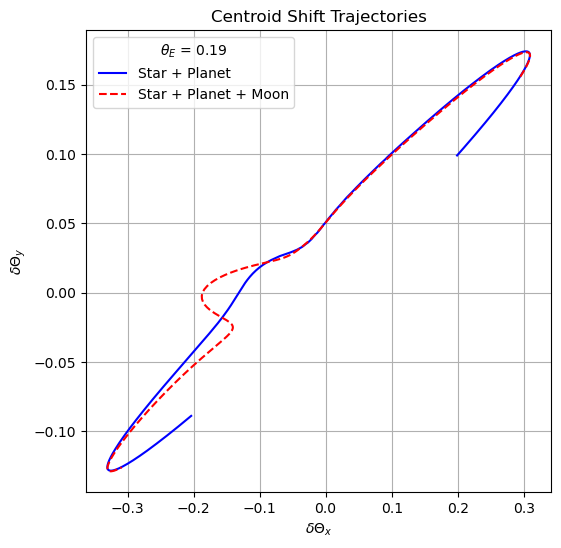

In [63]:
plt.figure(figsize=(6,6))
plt.plot(delta_x_two, delta_y_two, 'b-', label='Star + Planet')
plt.plot(delta_x_three, delta_y_three, 'r--', label='Star + Planet + Moon')
plt.xlabel(r"$\delta \Theta_x$")
plt.ylabel(r"$\delta \Theta_y$")
plt.title("Centroid Shift Trajectories")
plt.grid(True)
plt.legend(title=fr"$\theta_E$ = {theta_E_mas:.2f}")
plt.show()

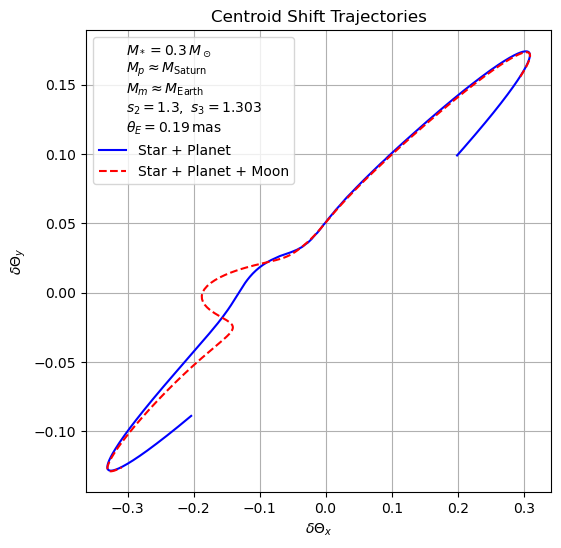

In [65]:
plt.figure(figsize=(6,6))
plt.plot(delta_x_two, delta_y_two, 'b-', label='Star + Planet')
plt.plot(delta_x_three, delta_y_three, 'r--', label='Star + Planet + Moon')
plt.xlabel(r"$\delta \Theta_x$")
plt.ylabel(r"$\delta \Theta_y$")
plt.title("Centroid Shift Trajectories")
plt.grid(True)

setup_str = (
    r"$M_*=0.3\,M_\odot$" + "\n"
    r"$M_p\approx M_{\rm Saturn}$" + "\n"
    r"$M_m\approx M_{\rm Earth}$" + "\n"
    r"$s_2=1.3,\ s_3=1.303$" + "\n"
    rf"$\theta_E = {theta_E_mas:.2f}\,{{\rm mas}}$"
)
plt.legend(title=setup_str)


plt.show()

In [76]:
double_model2 = TwoLens1S(t0, tE, rho, u0_list, q4, s2, 25, t_lc)

In [77]:
double_model_tau2 = double_model2.tau_lc
double_model_mag2 = double_model2.systems[0]["mag"]

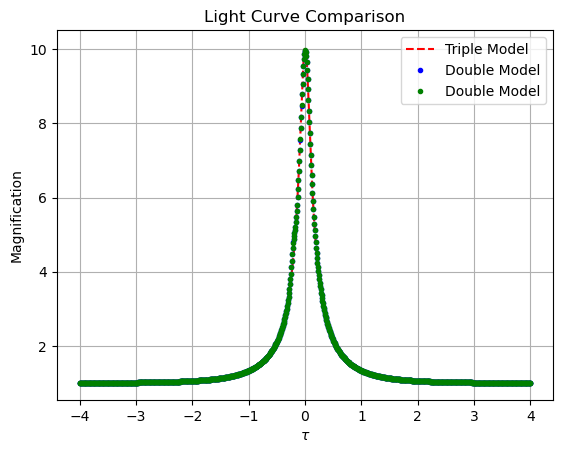

In [138]:
plt.plot(triple_model_tau, triple_model_mag, '--', label = "Triple Model", color = 'red')
plt.plot(double_model_tau2, double_model_mag2, '.b', label="Double Model")
plt.plot(double_model_tau, double_model_mag, '.g', label="Double Model")

#plt.xlim(-.25, .25)
#plt.ylim(9, 10.5)

plt.xlabel(r"$\tau$")
plt.ylabel("Magnification")
plt.title("Light Curve Comparison")
plt.grid(True)
plt.legend()
plt.show()

In [79]:
two_system = double_model2.systems[0]
three_system = triple_model.systems[0]

# Differences relative to source
delta_x_two = two_system['cent_x_hr'] - two_system['x_src_hr']
delta_y_two = two_system['cent_y_hr'] - two_system['y_src_hr']

delta_x_three = three_system['cent_x'] - three_system['y1s']
delta_y_three = three_system['cent_y'] - three_system['y2s']

delta_x_three = - delta_x_three
delta_y_three = delta_y_three

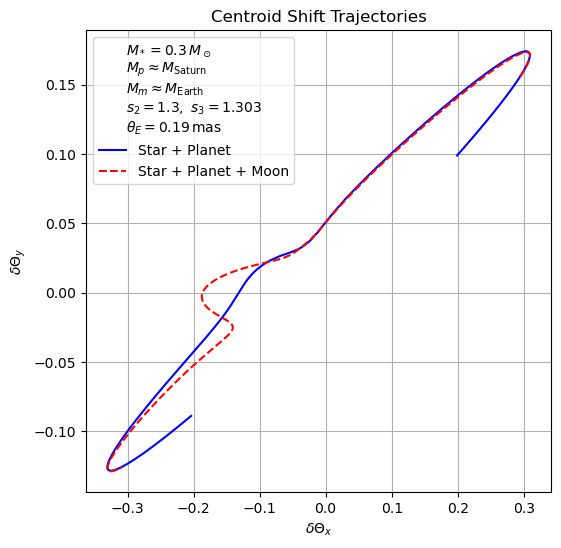

In [80]:
plt.figure(figsize=(6,6))
plt.plot(delta_x_two, delta_y_two, 'b-', label='Star + Planet')
plt.plot(delta_x_three, delta_y_three, 'r--', label='Star + Planet + Moon')
plt.xlabel(r"$\delta \Theta_x$")
plt.ylabel(r"$\delta \Theta_y$")
plt.title("Centroid Shift Trajectories")
plt.grid(True)

setup_str = (
    r"$M_*=0.3\,M_\odot$" + "\n"
    r"$M_p\approx M_{\rm Saturn}$" + "\n"
    r"$M_m\approx M_{\rm Earth}$" + "\n"
    r"$s_2=1.3,\ s_3=1.303$" + "\n"
    rf"$\theta_E = {theta_E_mas:.2f}\,{{\rm mas}}$"
)
plt.legend(title=setup_str)


plt.show()

In [99]:
trial1 = TwoLens1S(t0, tE, rho, u0_list, q2, s2, 25, t_lc)
trial2 = TwoLens1S(t0, tE, rho, u0_list, q4, s2, 25, t_lc)

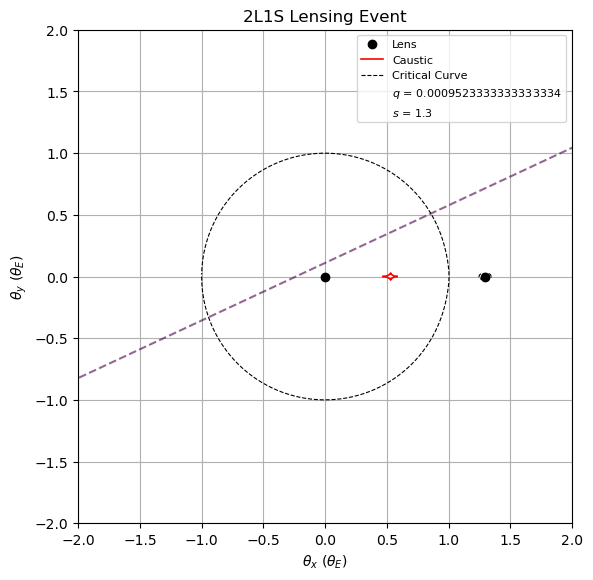

In [100]:
trial1.plot_caustic_critical_curves()

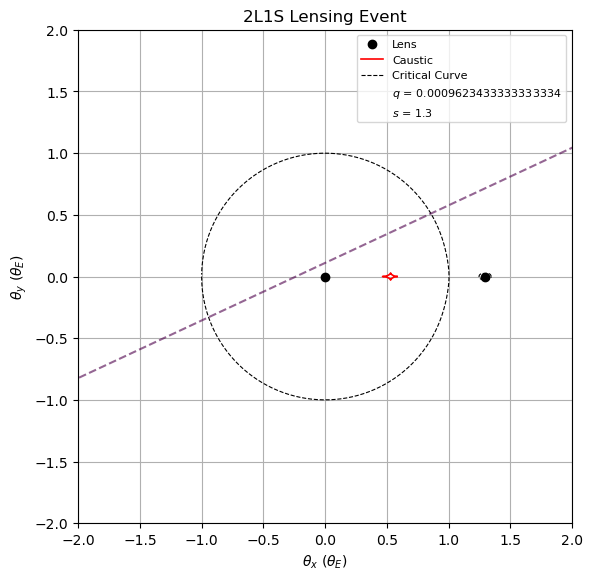

In [101]:
trial2.plot_caustic_critical_curves()

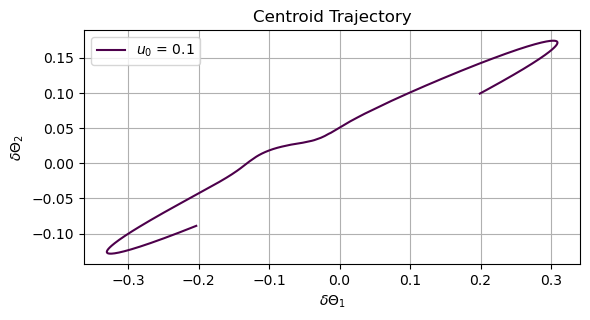

In [102]:
trial1.plot_centroid_trajectory()

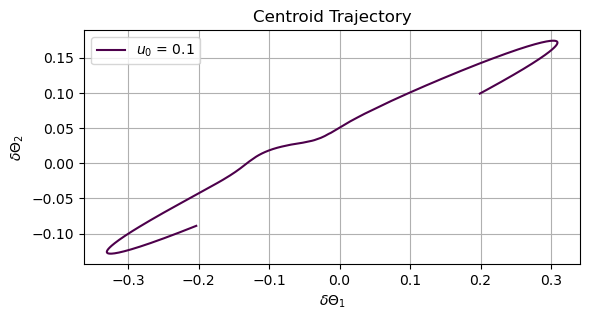

In [103]:
trial2.plot_centroid_trajectory()

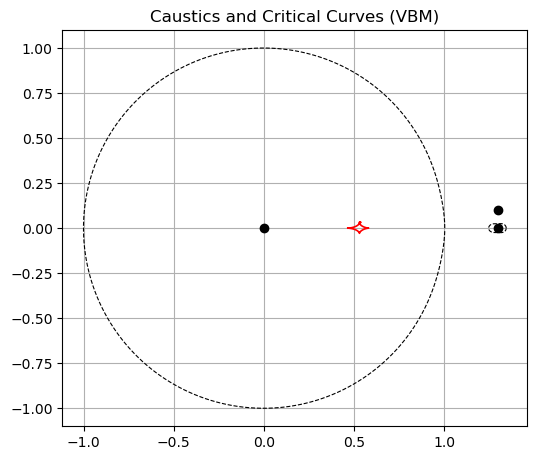

In [96]:
triple_model.plot_caustics_and_critical()

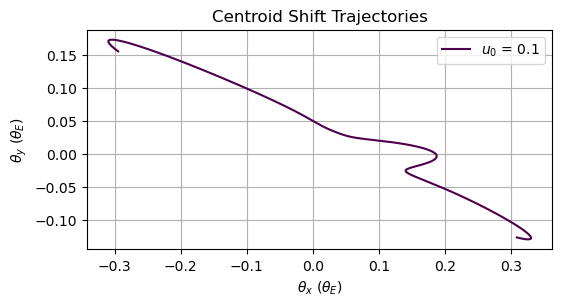

In [97]:
triple_model.plot_centroid_trajectory()

In [104]:
print(s2)

1.3


# Changing Distance

In [105]:
s2_1 = s2 * 0.3
s2_2 = s2 * 0.5
s2_3 = s2 * 0.7
s2_4 = s2 * 1.0
s2_5 = s2 * 1.2

In [106]:
d1 = TwoLens1S(t0, tE, rho, u0_list, q2, s2_1, 25, t_lc)
d1_m = TwoLens1S(t0, tE, rho, u0_list, q4, s2_1, 25, t_lc)

d2 = TwoLens1S(t0, tE, rho, u0_list, q2, s2_2, 25, t_lc)
d2_m = TwoLens1S(t0, tE, rho, u0_list, q4, s2_2, 25, t_lc)

d3 = TwoLens1S(t0, tE, rho, u0_list, q2, s2_3, 25, t_lc)
d3_m = TwoLens1S(t0, tE, rho, u0_list, q4, s2_3, 25, t_lc)

d4 = TwoLens1S(t0, tE, rho, u0_list, q2, s2_4, 25, t_lc)
d4_m = TwoLens1S(t0, tE, rho, u0_list, q4, s2_4, 25, t_lc)

d5 = TwoLens1S(t0, tE, rho, u0_list, q2, s2_5, 25, t_lc)
d5_m = TwoLens1S(t0, tE, rho, u0_list, q4, s2_5, 25, t_lc)

In [116]:
run1 = d1.systems[0]
delta_x_d1 = run1['cent_x_hr'] - run1['x_src_hr']
delta_y_d1 = run1['cent_y_hr'] - run1['y_src_hr']

run1_m = d1_m.systems[0]
delta_x_d1_m = run1_m['cent_x_hr'] - run1_m['x_src_hr']
delta_y_d1_m = run1_m['cent_y_hr'] - run1_m['y_src_hr']

#########################################################

run2 = d2.systems[0]
delta_x_d2 = run2['cent_x_hr'] - run2['x_src_hr']
delta_y_d2 = run2['cent_y_hr'] - run2['y_src_hr']

run2_m = d2_m.systems[0]
delta_x_d2_m = run2_m['cent_x_hr'] - run2_m['x_src_hr']
delta_y_d2_m = run2_m['cent_y_hr'] - run2_m['y_src_hr']

#########################################################

run3 = d3.systems[0]
delta_x_d3 = run3['cent_x_hr'] - run3['x_src_hr']
delta_y_d3 = run3['cent_y_hr'] - run3['y_src_hr']

run3_m = d3_m.systems[0]
delta_x_d3_m = run3_m['cent_x_hr'] - run3_m['x_src_hr']
delta_y_d3_m = run3_m['cent_y_hr'] - run3_m['y_src_hr']

#########################################################

run4 = d4.systems[0]
delta_x_d4 = run4['cent_x_hr'] - run4['x_src_hr']
delta_y_d4 = run4['cent_y_hr'] - run4['y_src_hr']

run4_m = d4_m.systems[0]
delta_x_d4_m = run4_m['cent_x_hr'] - run4_m['x_src_hr']
delta_y_d4_m = run4_m['cent_y_hr'] - run4_m['y_src_hr']

#########################################################

run5 = d5.systems[0]
delta_x_d5 = run5['cent_x_hr'] - run5['x_src_hr']
delta_y_d5 = run5['cent_y_hr'] - run5['y_src_hr']

run5_m = d5_m.systems[0]
delta_x_d5_m = run5_m['cent_x_hr'] - run5_m['x_src_hr']
delta_y_d5_m = run5_m['cent_y_hr'] - run5_m['y_src_hr']

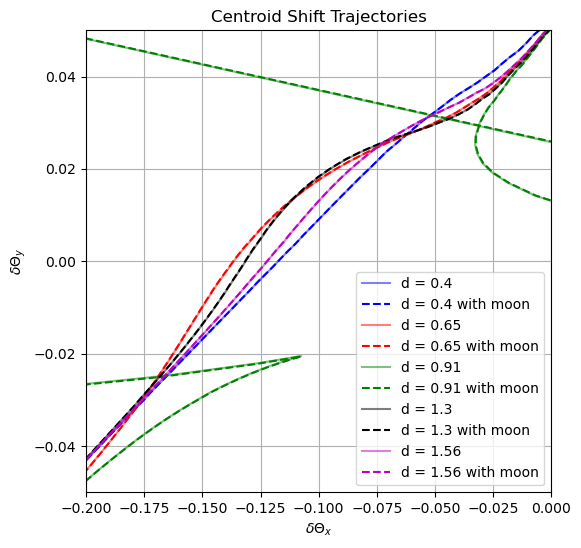

In [127]:
plt.figure(figsize=(6,6))

plt.plot(delta_x_d1, delta_y_d1, 'b-', label='d = 0.4', alpha = 0.5)
plt.plot(delta_x_d1_m, delta_y_d1_m, 'b--', label='d = 0.4 with moon')

plt.plot(delta_x_d2, delta_y_d2, 'r-', label='d = 0.65', alpha = 0.5)
plt.plot(delta_x_d2_m, delta_y_d2_m, 'r--', label='d = 0.65 with moon')

plt.plot(delta_x_d3, delta_y_d3, 'g-', label='d = 0.91', alpha = 0.5)
plt.plot(delta_x_d3_m, delta_y_d3_m, 'g--', label='d = 0.91 with moon')

plt.plot(delta_x_d4, delta_y_d4, 'k-', label='d = 1.3', alpha = 0.5)
plt.plot(delta_x_d4_m, delta_y_d4_m, 'k--', label='d = 1.3 with moon')

plt.plot(delta_x_d5, delta_y_d5, 'm-', label='d = 1.56', alpha = 0.5)
plt.plot(delta_x_d5_m, delta_y_d5_m, 'm--', label='d = 1.56 with moon')

plt.xlim(-.2,0)
plt.ylim(-0.05,0.05)

plt.xlabel(r"$\delta \Theta_x$")
plt.ylabel(r"$\delta \Theta_y$")
plt.title("Centroid Shift Trajectories")
plt.grid(True)
plt.legend()
plt.show()

# Changing Distances

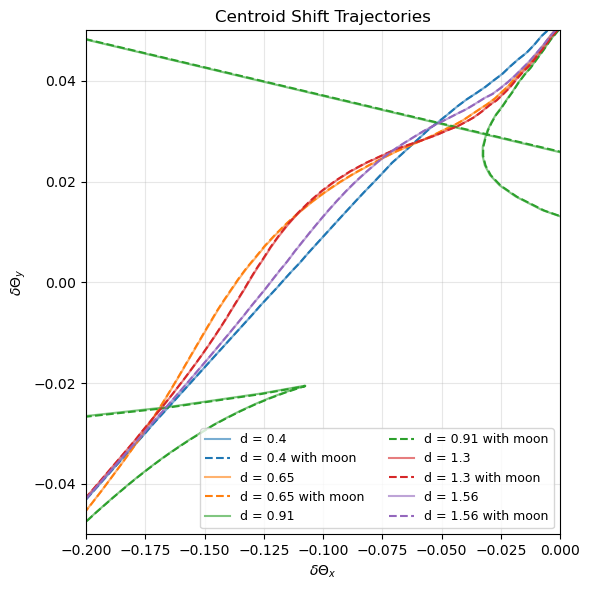

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

factors   = [0.3, 0.5, 0.7, 1.0, 1.2]                 
labels    = ['d = 0.4','d = 0.65','d = 0.91','d = 1.3','d = 1.56']  
colors    = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']  

def run_model(q, s2_val):
    m = TwoLens1S(t0, tE, rho, u0_list, q, s2_val, 25, t_lc)
    sys = m.systems[0]
    dx = sys['cent_x_hr'] - sys['x_src_hr']
    dy = sys['cent_y_hr'] - sys['y_src_hr']
    return dx, dy

plt.figure(figsize=(6,6))

max_offsets = []
for fac, lab, col in zip(factors, labels, colors):
    s2_val = s2 * fac

    # no-moon 
    dx,  dy  = run_model(q2, s2_val)
    # moon + planet
    dxm, dym = run_model(q4, s2_val)

    # plot pair
    plt.plot(dx,  dy,  '-',  color=col, label=lab, alpha=0.6)
    plt.plot(dxm, dym, '--', color=col, label=f'{lab} with moon')

    # quick metric: max separation between the two centroid tracks
    n = min(len(dx), len(dxm))
    dsep = np.hypot(dx[:n]-dxm[:n], dy[:n]-dym[:n]).max()
    max_offsets.append((lab, dsep))

plt.xlim(-0.2, 0)
plt.ylim(-0.05, 0.05)
plt.xlabel(r"$\delta \Theta_x$")
plt.ylabel(r"$\delta \Theta_y$")
plt.title("Centroid Shift Trajectories")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()

# Changing Mass

/var/folders/v4/bz37477x3gq_4txqv7sy3j1c0000gn/T/ipykernel_3501/3265870106.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')  # or 'turbo', 'plasma', etc.


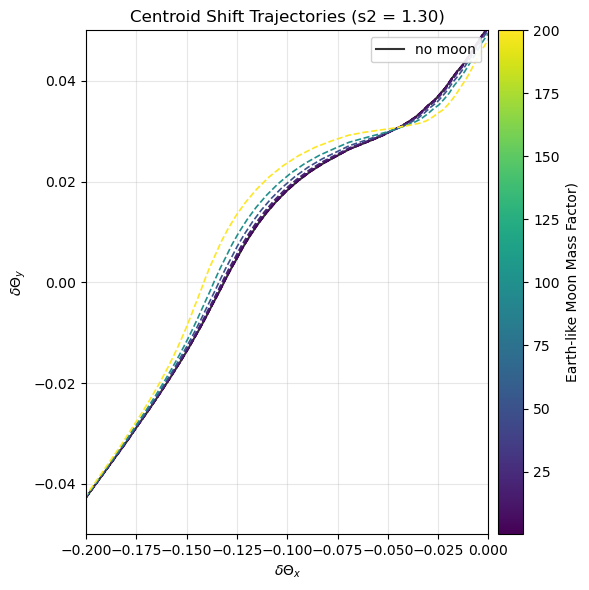

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap, ScalarMappable

s2_val = s2 * 1.0
q_moon_earth = m3  
mass_multipliers = [0.1, 0.5, 1, 2, 5, 10, 20, 50, 100, 200]

def run_model(q, s2_value):
    m = TwoLens1S(t0, tE, rho, u0_list, q, s2_value, 25, t_lc)
    sys = m.systems[0]
    dx = sys['cent_x_hr'] - sys['x_src_hr']
    dy = sys['cent_y_hr'] - sys['y_src_hr']
    return dx, dy

# Baseline (no moon)
dx0, dy0 = run_model(q2, s2_val)


fig, ax = plt.subplots(figsize=(6,6))
ax.plot(dx0, dy0, '-', color='k', lw=1.5, label='no moon', alpha=0.8)

norm = Normalize(vmin=min(mass_multipliers), vmax=max(mass_multipliers))
cmap = get_cmap('viridis')  
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

max_offsets = []
for k in mass_multipliers:
    q4_k = q2 + k * q_moon_earth
    dx, dy = run_model(q4_k, s2_val)
    ax.plot(dx, dy, '--', color=sm.to_rgba(k), lw=1.2)

    n = min(len(dx0), len(dx))
    dsep = np.hypot(dx[:n]-dx0[:n], dy[:n]-dy0[:n]).max()
    max_offsets.append((k, dsep))

cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label('Earth-like Moon Mass Factor)')

ax.set_xlim(-0.2, 0); ax.set_ylim(-0.05, 0.05)
ax.set_xlabel(r"$\delta \Theta_x$")
ax.set_ylabel(r"$\delta \Theta_y$")
ax.set_title(f"Centroid Shift Trajectories (s2 = {s2_val:.2f})")
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', framealpha=0.9)
plt.tight_layout()
plt.show()


# Changing Position of Moon

In [144]:
angles = [0, 45, 90, 135, 180, 225, 270, 315, 360]

s2 = 1.3   # example star-planet distance
d = 0.1    # example planet-moon distance

results = []
for phi in angles:
    s3, psi = Moon_Geometry(s2, d, phi)
    results.append((phi, s3, psi))

# Print nicely
for phi, s3, psi in results:
    print(f"phi = {phi}° -> s3 = {s3:.3f}, psi = {psi:.2f}°")

phi = 0° -> s3 = 1.400, psi = 0.00°
phi = 45° -> s3 = 1.373, psi = 2.95°
phi = 90° -> s3 = 1.304, psi = 4.40°
phi = 135° -> s3 = 1.231, psi = 3.29°
phi = 180° -> s3 = 1.200, psi = 0.00°
phi = 225° -> s3 = 1.231, psi = -3.29°
phi = 270° -> s3 = 1.304, psi = -4.40°
phi = 315° -> s3 = 1.373, psi = -2.95°
phi = 360° -> s3 = 1.400, psi = -0.00°


In [145]:
s3_1 = 1.4
s3_2 = 1.373
s3_3 = 1.305
s3_4 = 1.231
s3_5 = 1.200
s3_6 = 1.231
s3_7 = 1.304
s3_8 = 1.373

psi_1 = 0.00
psi_2 = 2.95
psi_3 = 4.40
psi_4 = 3.29
psi_5 = 0
psi_6 = -3.29
psi_7 = -4.40
psi_8 = -2.95

In [146]:
ex1 = TwoLens1S(t0, tE, rho, u0_list, q2, s2, 25, t_lc)
ex1_m = ThreeLens1S(t0, tE, rho, u0_list, q2, q3, s2, s3_1, 25, psi_1, rs, secnum, basenum, num_points)

param = [
    np.log(ex1_m.s2), np.log(ex1_m.q2), ex1_m.u0_list[0], ex1_m.alpha_deg,
    np.log(ex1_m.rho), np.log(ex1_m.tE), ex1_m.t0,
    np.log(ex1_m.s3), np.log(ex1_m.q3), ex1_m.psi_rad
]
mag, *_ = ex1_m.VBM.TripleLightCurve(param, ex1_m.highres_t)

two_system = ex1.systems[0]
three_system = ex1_m.systems[0]

delta_x_two = two_system['cent_x_hr'] - two_system['x_src_hr']
delta_y_two = two_system['cent_y_hr'] - two_system['y_src_hr']

delta_x_three = three_system['cent_x'] - three_system['y1s']
delta_y_three = three_system['cent_y'] - three_system['y2s']

delta_x_three = - delta_x_three
delta_y_three = delta_y_three